# Ensembles of Decision Trees

## Random forests

Principle : a random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

### First test

In [2]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = RandomForestClassifier(random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.844


It can be seen that compared to the single decision tree, we get better results, without tuning any parameters.

### Further tests

Let's now carry on with a bigger dataset and try with different values of the parameters.

In [2]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

#### Number of trees

*n_estimators* represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

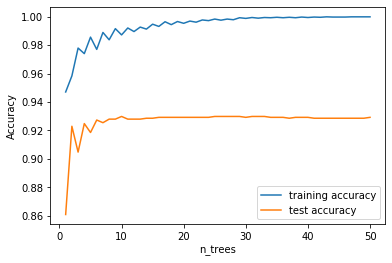

In [3]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 51)
for f in settings:
    clf = RandomForestClassifier(n_estimators=f, n_jobs=-1, random_state=0) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_trees")
plt.legend()

It looks like in this case the more trees we build the more accurate our model gets, eventhough a small spike at *n=10* seems to provide better results for the test set.

#### Depth

*max_depth* represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32 and plot the training and test errors.

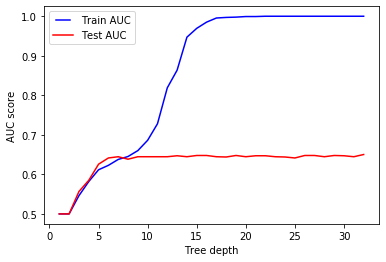

In [6]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(data_train, target_train)
   train_pred = rf.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

We see that our model overfits for large depth values. The trees perfectly predicts all of the train data, however, it fails to generalize the findings for new data.

#### Minimum number of samples (split)

*min_samples_split* represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, each tree in the forest becomes more constrained as it has to consider more samples at each node.

In [10]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = RandomForestClassifier(min_samples_split=i) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 2
Accuracy on training set: 1.000
Accuracy on test set: 0.930
min_samples_split set to 3
Accuracy on training set: 1.000
Accuracy on test set: 0.928
min_samples_split set to 4
Accuracy on training set: 1.000
Accuracy on test set: 0.929
min_samples_split set to 5
Accuracy on training set: 0.998
Accuracy on test set: 0.929
min_samples_split set to 6
Accuracy on training set: 0.997
Accuracy on test set: 0.930
min_samples_split set to 7
Accuracy on training set: 0.993
Accuracy on test set: 0.930
min_samples_split set to 8
Accuracy on training set: 0.989
Accuracy on test set: 0.929
min_samples_split set to 9
Accuracy on training set: 0.982
Accuracy on test set: 0.929
min_samples_split set to 10
Accuracy on training set: 0.978
Accuracy on test set: 0.930


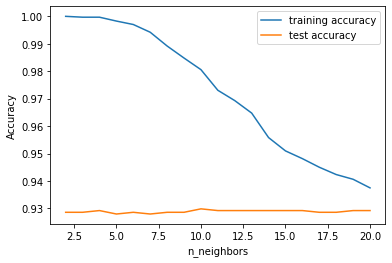

In [6]:
training_accuracy = [] 
test_accuracy = []
settings = range(2, 21)
for v in settings:
    clf = RandomForestClassifier(min_samples_split=v)  
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_split")
plt.legend()

We can see that in this case improving the minimum value doesn't necessarily improve the accuracy, so we can keep the default value.

#### Minimum number of samples (leaf)

*min_samples_leaf* is the minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples at the leafs, the base of the tree.

In [12]:
for i in range(1,11):
    print("min_samples_split set to %s" % i)
    tree = RandomForestClassifier(min_samples_leaf=i) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

min_samples_split set to 1
Accuracy on training set: 1.000
Accuracy on test set: 0.929
min_samples_split set to 2
Accuracy on training set: 0.995
Accuracy on test set: 0.930
min_samples_split set to 3
Accuracy on training set: 0.967
Accuracy on test set: 0.930
min_samples_split set to 4
Accuracy on training set: 0.943
Accuracy on test set: 0.930
min_samples_split set to 5
Accuracy on training set: 0.932
Accuracy on test set: 0.929
min_samples_split set to 6
Accuracy on training set: 0.927
Accuracy on test set: 0.929
min_samples_split set to 7
Accuracy on training set: 0.926
Accuracy on test set: 0.929
min_samples_split set to 8
Accuracy on training set: 0.924
Accuracy on test set: 0.929
min_samples_split set to 9
Accuracy on training set: 0.924
Accuracy on test set: 0.929
min_samples_split set to 10
Accuracy on training set: 0.924
Accuracy on test set: 0.928


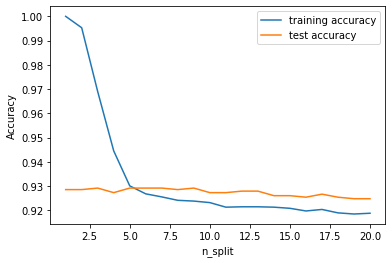

In [8]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 21)
for v in settings:
    clf = RandomForestClassifier(min_samples_leaf=v)  
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_split")
plt.legend()

Same conclusion as the last experiment. A good compromise seems to be at *n=5*.

#### Number of features

*max_features* represents the number of features to consider when looking for the best split. Since we're working with 119 different features, let's try all the values and see how relevant they are.

In [14]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 120)
for f in settings:
    clf = RandomForestClassifier(max_features=f, n_jobs=-1)
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

KeyboardInterrupt: 

### Best match

In [9]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [ ]:
parameters = {'n_estimators': np.arange(1,21), 'max_depth': np.arange(1,21), 'min_samples_split': np.arange(1,11), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120)}
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

In [ ]:
parameters = {'n_estimators': np.arange(1,21), 'max_depth': np.arange(1,21), 'min_samples_split': np.arange(1,11), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120)}
clf = RandomizedSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

## Gradient boosted regression trees

Principle : In contrast to the random forest approach, gradient boosting works by building trees in a serial man‐ ner, where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong pre-pruning is used. Gradient boosted trees often use very shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster. Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

### First test

In [5]:
gt = pd.read_csv('../dumps/2020.01.13-14.25.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

tree = GradientBoostingClassifier(random_state=0)
tree.fit(data_train, target_train)
print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

Accuracy on training set: 0.981
Accuracy on test set: 0.819


As the training set accuracy is quite close to 100% and the test set accuracy is pretty low, we are likely to be overfitting. To reduce this overfitting, we mght try to apply pre-pruning by limiting the maximum depth or lower the learning rate.

### Further test

Let's now carry on with a bigger dataset and try with different values of the parameters.

In [6]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']

data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

#### Depth

In [7]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = GradientBoostingClassifier(max_depth=max_depth, random_state=0)
   rf.fit(data_train, target_train)
   train_pred = rf.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

KeyboardInterrupt: 

#### Learning rate

*learning_rate* shrinks the contribution of each tree by learning_rate.

In [ ]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta)
   model.fit(data_train, target_train)
   train_pred = model.predict(data_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(data_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

#### Number of trees

In [ ]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 201)
for f in settings:
    clf = GradientBoostingClassifier(n_estimators=f, n_jobs=-1, random_state=0) 
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_trees")
plt.legend()

#### Minimum number of samples (split)

In [ ]:
for i in range(2,11):
    print("min_samples_split set to %s" % i)
    tree = GradientBoostingClassifier(min_samples_split=i) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

#### Minimum number of samples (leaf)

In [ ]:
for i in range(1,11):
    print("min_samples_split set to %s" % i)
    tree = GradientBoostingClassifier(min_samples_leaf=i) 
    tree.fit(data_train, target_train)
    print("Accuracy on training set: {:.3f}".format(tree.score(data_train, target_train))) 
    print("Accuracy on test set: {:.3f}".format(tree.score(data_test, target_test)))

#### Number of features

In [ ]:
training_accuracy = [] 
test_accuracy = []
settings = range(1, 120)
for f in settings:
    clf = GradientBoostingClassifier(max_features=f, n_jobs=-1)
    clf.fit(data_train, target_train)
    training_accuracy.append(clf.score(data_train, target_train))
    test_accuracy.append(clf.score(data_test, target_test))
plt.plot(settings, training_accuracy, label="training accuracy") 
plt.plot(settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_features")
plt.legend()

### Best match

In [10]:
gt = pd.read_csv('../dumps/2020.02.10-12.14.csv')
cols = [col for col in gt.columns if col not in ['label']]
data = gt[cols]
target = gt['label']
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size = 0.20, random_state = 0)

In [ ]:
parameters = {'n_estimators': np.arange(1,21), 'max_depth': np.arange(1,21), 'min_samples_split': np.arange(1,11), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120), 'learning_rate':[0.01,0.1,0.25,0.5,1.0]}
clf = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)

In [ ]:
parameters = {'n_estimators': np.arange(1,21), 'max_depth': np.arange(1,21), 'min_samples_split': np.arange(1,11), 'min_samples_leaf': np.arange(1,11), 'max_features': np.arange(1,120), 'learning_rate':[0.01,0.1,0.25,0.5,1.0]}
clf = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1)
clf.fit(data_train, target_train)
print(clf.score(data_train, target_train))
print(clf.best_params_)
print(clf.score(data_test, target_test))
print(clf.best_params_)